In [1]:
from src.data.data_management import DataManagement
from src.NN_model.NeuralNetworkModel import NeuralNetworkModel
from src.NN_model.basic_metrics import basic_metrics
from src.vis.visualize import Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets

# Optimalization methods of Neural Networks
In this notebook I will present methods, that helps neural network to learn faster and/or avoiding oscilating around local optima. Optimalization technniques are as follows:
- minibatch gradient descent
- momentum optimalization
- rms_prop oplimalization
- adam optimalization
- learning rate decay

The NeuralNetworkModel that I used earlier was developed and optimalization techniques that I mentioned, were added.

<strong>Note</strong>: In this notebook I will only concentrate on optimalization techniques, which helps to learn as fast as possible. I will only take into consideration how fast/in how many iterations my algorithims minimize cost function. I won't use any regularization techniques to prevent overfitting - model will be overfitting the data, but thats the point of this notebook - I only want to analyze how those technqiues fasten learning. Even if the model is overfitted it does not mean it did not learn. It did, but not in proprer way in which it can generalize well on new data.
## Visualization of dataset
In this notebook I will be using some dataset provided by *sklearn.datasets* library

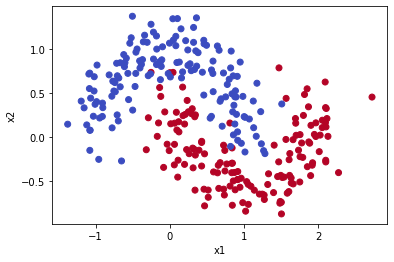

In [2]:
train_x, train_y = sklearn.datasets.make_moons(n_samples=300, noise=0.2)
train_x, train_y = train_x.T, train_y.reshape((1, -1))
plt.scatter(train_x[0], train_x[1], c=train_y, cmap=plt.cm.coolwarm)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Training models with respect to optimalization technique
Basic optimization method in machine learning is gradient descent (GD). Gradient descent can have 3 types:
- batch gradient descent - when you take gradient steps with respect to all training examples on each step
- mini-batch gradient descent - when you take gradient steps with respect to partition of your training examples
- stochastic gradient descent  - when you take gradient steps with respect to one training example

Every each of this method has its upsides and downsides - for example batch gradient descent learn pretty slow, but it should always minimize cost function (or at last do not increase its value). On the other hand, SGD can be faster, but the parameters will "oscillate" toward the minimum rather than converge smoothly. Mini-batch GD is somewhere in between stochastic and batch GD.

Before we start, let's define those parameters, which every model is going to use.

**Note**: There is a parameter called *num_epchos*. An *epoch* in machine learning means one complete pass of the training dataset through the algorithm

In [3]:
hidden_layer_dims = [8, 4]
num_epochs = 5000
l_rate = 0.003
save_cost = 100
print_cost = 1000

All models will use the same default activation function ReLu.

Let's also create DataFrame that will store values of cost functions (I am using multi-indexing for the later use of <em>gradient_visualization</em> method).
Later on I will also create a DataFrame for metrics.

<strong>Last but not least</strong>, the decision boundary of a trained model is going to be plotted just after training, but I am going to store values of costs functions and metrics in dataframes. This is because it will be easier to compare models after every each one of them is trained.

In [4]:
indexes = [['no learning rate decay']*5, ['BGD', 'Mini-BGD', "momentum", "rms_prop", "adam"]]
models_costs = pd.DataFrame(columns=['cost'], index=indexes)

### Batch gradient descent
As mentioned earlier BDG take gradient step with respect to all training examples. I implemented an algorithim in this way - if passed 0 as a value of *mini_batch_size*, mini-batch size will be equal to all training examples, i.e. this is BGD.

In [5]:
np.random.seed(3)
optimizer = "BGD"
model_bgd = NeuralNetworkModel(hidden_layer_dims, optimizer='gd', mini_batch_size=0,
                               num_epochs=num_epochs, learning_rate = l_rate, save_costs=save_cost, print_cost=print_cost)
model_bgd.fit(train_x, train_y)

Cost after iteration 0: 0.6151226241173132
Cost after iteration 1000: 0.4710569856342183
Cost after iteration 2000: 0.4126539130671537
Cost after iteration 3000: 0.3786032316756828
Cost after iteration 4000: 0.35625765180313596
Cost after iteration 4999: 0.34029020704090784


Lets do prediction on a training set, calculate metrics and save them. Costs values registered during training will be saved as well. We are going to come back to this results in the summary

In [6]:
preds_bgd = model_bgd.predict(train_x)
proba_bgd = model_bgd.predict_proba(train_x)
model_bgd_metrics = basic_metrics(train_y, preds_bgd, proba_bgd)
metrics = pd.DataFrame(columns=list(model_bgd_metrics.keys()))
metrics.loc[optimizer] = model_bgd_metrics

In [7]:
models_costs.loc[("no learning rate decay", str(optimizer)), "cost"] = model_bgd.get_costs()

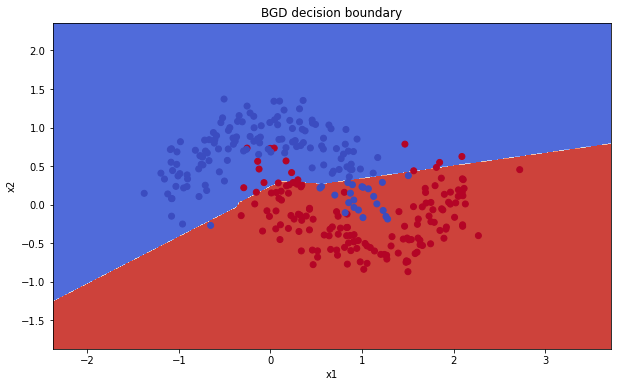

In [8]:
plt.figure(figsize=(10, 6))
plt.title("BGD decision boundary")
Visualization.plot_decision_boundary(lambda x: model_bgd.predict(x.T), train_x, train_y)

**Main information about BGD learning:**
- during 5000 complete passes gradient was updated 5000 times
- when the learning was finished, cost function was equal to 0.32

### Mini-batch gradient descent

Mini-batch gradient descent is a variation of the gradient descent algorithm that splits the training dataset into **small batches that are used to calculate model error and update model coefficients**. If gradients are updated more frequently, the cost function is going to be minimized faster/ealier.

The **main idea behind gradient descent algorithm** is as follows:
- **shuffle** the training set
- **partition** the shuffled training set into mini-batches of size mini_batch_size. If the number of training examples is not divisible by mini_batch_size, the last mini batch will just be smaller.

Main adventages:
- easily fits in the memory
- it is computationally efficient
- benefit from vectorization
- if stuck in local minimums, some noisy steps can lead the way out of them
- average of the training samples produces stable error gradients and convergence

Let's see how it work, with mini-batch size 64

In [9]:
np.random.seed(3)
optimizer = "Mini-BGD"
model_mini_bgd = NeuralNetworkModel(hidden_layer_dims, optimizer='gd', mini_batch_size=64,
                               num_epochs=num_epochs, learning_rate = l_rate, save_costs=save_cost, print_cost=print_cost)
model_mini_bgd.fit(train_x, train_y)

Cost after iteration 0: 0.614385784912836
Cost after iteration 1000: 0.34032098687073625
Cost after iteration 2000: 0.2917434409001951
Cost after iteration 3000: 0.2501687310819606
Cost after iteration 4000: 0.2054278891577587
Cost after iteration 4999: 0.16528740659109126


In [10]:
preds_mini_bgd = model_mini_bgd.predict(train_x)
proba_mini_bgd = model_mini_bgd.predict_proba(train_x)
metrics.loc[optimizer] = basic_metrics(train_y, preds_mini_bgd, preds_mini_bgd)
models_costs.loc[("no learning rate decay", str(optimizer)), "cost"] = model_mini_bgd.get_costs()

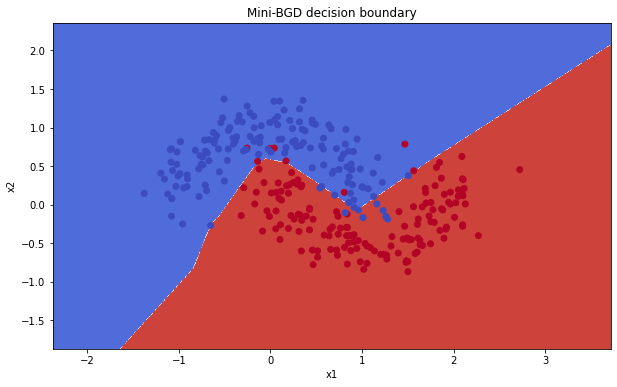

In [11]:
plt.figure(figsize=(10, 6))
plt.title("Mini-BGD decision boundary")
Visualization.plot_decision_boundary(lambda x: model_mini_bgd.predict(x.T), train_x, train_y)

**Main information about Mini-BGD learning:**
- during 5000 complete passes gradient was updated 5000 * ceil(5000/64) times. It means gradient was updated 79 times more often!
- when the learning was finished, cost function was equal to 0.21

### Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable *v* . This variable value is the exponentially weighted average of the gradient on previous steps. 

The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate

In [12]:
np.random.seed(3)
optimizer = "momentum"
model_momentum = NeuralNetworkModel(hidden_layer_dims, optimizer='momentum', mini_batch_size=64, beta1=0.9,
                               num_epochs=num_epochs, learning_rate = l_rate, save_costs=save_cost, print_cost=print_cost)
model_momentum.fit(train_x, train_y)

Cost after iteration 0: 0.6150030708757641
Cost after iteration 1000: 0.3403501261431602
Cost after iteration 2000: 0.29182947696178785
Cost after iteration 3000: 0.2502862452707259
Cost after iteration 4000: 0.20557271221737577
Cost after iteration 4999: 0.16542801929084044


In [13]:
preds_momentum = model_momentum.predict(train_x)
proba_momentum = model_momentum.predict_proba(train_x)
metrics.loc[optimizer] = basic_metrics(train_y, preds_momentum, proba_momentum)
models_costs.loc[("no learning rate decay", str(optimizer)), "cost"] = model_momentum.get_costs()

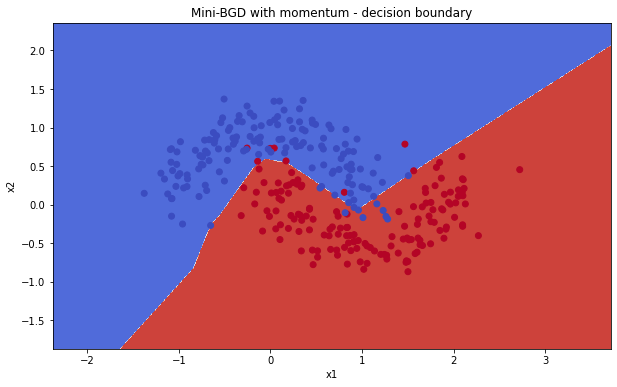

In [14]:
plt.figure(figsize=(10, 6))
plt.title("Mini-BGD with momentum - decision boundary")
Visualization.plot_decision_boundary(lambda x: model_momentum.predict(x.T), train_x, train_y)

**Main information about Mini-BGD with momentum learning:**
- gradient was updated 79 times more often than in BGD (the same case as in mini-batch GD)
- when the learning was finished, cost function was equal to 0.21

Because this example is relatively simple, the gains from using momemtum are small - but for more complex problems momentum might leads to bigger gains.

### RMS Prop
RMS (**Root Mean Square**) prop also takes into account the past gradients to smooth out the update. The exponentially weighted average of the root mean squared values of previous gradients are stored in the variable *s*. The formula for s and the update rule is as follows:

The update rule is, for $l = 1, ..., L$: 
$$\begin{cases}
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
W^{[l]} = W^{[l]} - \alpha \frac{dW^{[l]}}{\sqrt{s_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- L is the number of layers
- $\beta_2$ is a hyperparameter that control the exponentially weighted averages of root mean square gradient values
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

So let's see how it works on an example:
- if oscilations of previous gradients are high (no matter the + or - sign, because it will be squared and then rooted), the value of *s* is going to be high. Then, when we get *dW*, that is high and divide it by *s* overall updated value will be smaller and gradient update will be smoother.
- if oscilations of previous gradients are small, and the new value of *dW* is also small, gradient will be just update smoothly
- if oscilations of previous gradients are small and new value of *dW* is high, gradient will be boosted and the big step will be taken in this gradient update

In all te above examples, there gradient oscilation are smaller. RMS prop helps to "stay on track" to the minimum

In [15]:
np.random.seed(3)
optimizer = "rms_prop"
model_rms_prop = NeuralNetworkModel(hidden_layer_dims, optimizer='rms_prop', mini_batch_size=64, beta2=0.99,
                               num_epochs=num_epochs, learning_rate = l_rate, save_costs=save_cost, print_cost=print_cost)
model_rms_prop.fit(train_x, train_y)

Cost after iteration 0: 0.5718641598753403
Cost after iteration 1000: 0.06446874378337077
Cost after iteration 2000: 0.057462476951589174
Cost after iteration 3000: 0.05697682251037859
Cost after iteration 4000: 0.054099269291284294
Cost after iteration 4999: 0.05864236105452286


In [16]:
preds_rms_prop = model_rms_prop.predict(train_x)
proba_rms_prop = model_rms_prop.predict_proba(train_x)
metrics.loc[optimizer] = basic_metrics(train_y, preds_rms_prop, proba_rms_prop)
models_costs.loc[("no learning rate decay", str(optimizer)), "cost"] = model_rms_prop.get_costs()

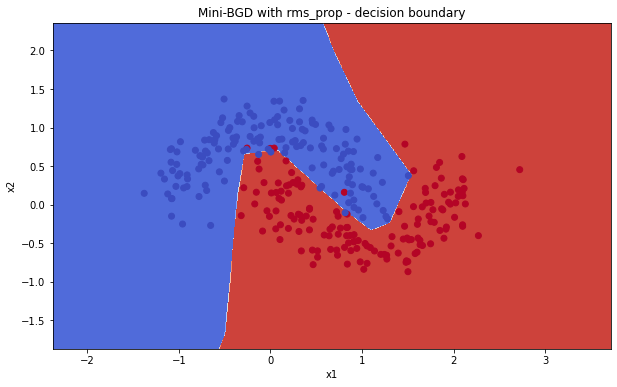

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Mini-BGD with rms_prop - decision boundary")
Visualization.plot_decision_boundary(lambda x: model_rms_prop.predict(x.T), train_x, train_y)

**Main information about Mini-BGD with RMS prop learning:**
- gradient was updated 79 times more often than in BGD (the same case as in mini-batch GD)
- when the learning was finished, cost function was equal to 0.06

The gains for rms prop are pretty impressing. In 1000 epochs, we get cost value of 0.06, better then other techniques after 5000 epochs.

### Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

In [18]:
np.random.seed(3)
optimizer = "adam"
model_adam = NeuralNetworkModel(hidden_layer_dims, optimizer='adam', mini_batch_size=64, beta1=0.9, beta2=0.99,
                               num_epochs=num_epochs, learning_rate = l_rate, save_costs=save_cost, print_cost=print_cost)
model_adam.fit(train_x, train_y)

Cost after iteration 0: 0.6105996884602863
Cost after iteration 1000: 0.062364879950194435
Cost after iteration 2000: 0.05977976574922799
Cost after iteration 3000: 0.059319470298823895
Cost after iteration 4000: 0.05786395058872832
Cost after iteration 4999: 0.057546295370898594


In [19]:
preds_adam = model_rms_prop.predict(train_x)
proba_adam = model_rms_prop.predict_proba(train_x)
metrics.loc[optimizer] = basic_metrics(train_y, preds_adam, proba_adam)
models_costs.loc[("no learning rate decay", str(optimizer)), "cost"] = model_adam.get_costs()

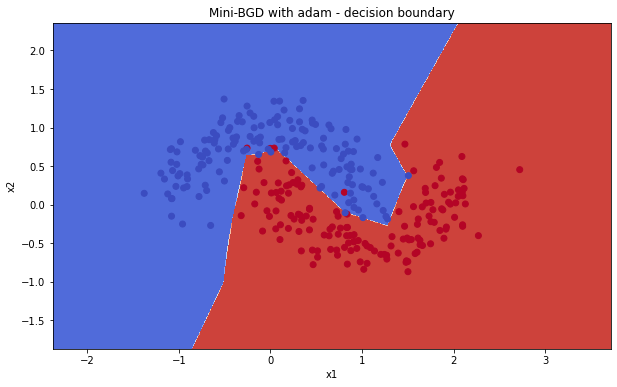

In [20]:
plt.figure(figsize=(10, 6))
plt.title("Mini-BGD with adam - decision boundary")
Visualization.plot_decision_boundary(lambda x: model_adam.predict(x.T), train_x, train_y)

**Main information about Mini-BGD with adam learning:**
- gradient was updated 79 times more often than in BGD (the same case as in mini-batch GD)
- when the learning was finished, cost function was equal to 0.06

The gains for adam are very similar to gains for rms_prop. It is because of the momentum factor - gains for momentum for simple problems are small, so we don't have adventages from that part.

### Summary
Quick recap, I have trained models with following optimalization techniques:
- Batch Gradient Descent (BDG)
- Mini-batch Gradient Descent (Mini-BDG)
- momentum
- rms prop
- adam

Let's see thier metrics and also let's see how fast cost function was minimized

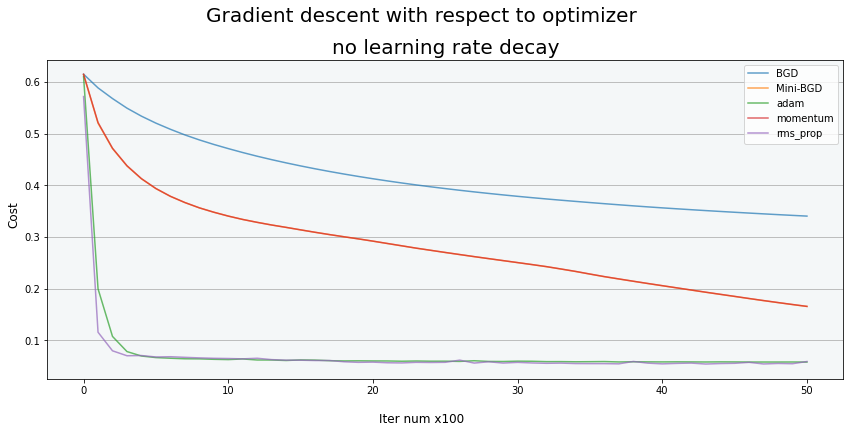

,accuracy,f1,precision,recall,AUC
BGD,0.866667,0.869281,0.852564,0.886667,0.934933
Mini-BGD,0.946667,0.946667,0.946667,0.946667,0.946667
momentum,0.946667,0.946667,0.946667,0.946667,0.989422
rms_prop,0.976667,0.976589,0.979866,0.973333,0.997956
adam,0.976667,0.976589,0.979866,0.973333,0.997956


In [21]:
Visualization.gradient_visualization(models_costs.cost, 100, "Gradient descent with respect to optimizer")
metrics

As we can see on a graph, a models that learned the fastest were rms-prop and adam. After about 200-300 epochs thier cost function values were lower than models with different optimalization techniques after 5000 epochs.

Metrics are the best for rms_prop and adam.

## Learning rate decay for multiple models
As we saw in example for rms_prop and adam optimalization, cost function after 300 epochs, stays at the same level and does not minmize futher (aroud 0.05 value). It is because, learning rate in this case is too big. It other examples - lets day Mini-batch GD, the learning rate is too small from the begining. We can deal with those issues with the usage of scheduled learning rate decay - it mean after *time_interval* iteration learning rate will decrease by a given vaule in denominator. The update rule is as follows:
$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

**Note:** The fraction in the denominator uses the floor operation.

Let's learn a models with each of optimizers and learning rate decay. Let's also change learning rate. Values of cost functions and metrics will be stored in dataframes

In [22]:
indexes = [['With learning rate decay']*5, ["BGD", 'Mini-BGD', "momentum", "rms_prop", "adam"]]
models_decay_costs = pd.DataFrame(columns=['cost'], index=indexes)
metrics_decay = None

In [23]:
for name, optimizer, size in zip(["BGD",'Mini-BGD', "momentum", "rms_prop", "adam"],
                                 ['gd','gd', "momentum", "rms_prop", "adam"], [0, 64, 64, 64, 64]):
    print(f"\nLearning a model with {name} optimalization")
    np.random.seed(3)
    model_decay = NeuralNetworkModel(hidden_layer_dims, optimizer=optimizer, mini_batch_size=size, beta1=0.9, beta2=0.99,
                                    decay=None, decay_rate=1, time_interval=1000, num_epochs=num_epochs,
                                    learning_rate = 0.02, save_costs=save_cost, print_cost=print_cost)
    model_decay.fit(train_x, train_y)
    models_decay_costs.loc[('With learning rate decay', str(name)), "cost"] = model_decay.get_costs()
    preds_decay = model_decay.predict(train_x)
    probas_decay = model_decay.predict_proba(train_x)
    acc_metrics = basic_metrics(train_y, preds_decay, probas_decay)
    if metrics_decay is None:
        metrics_decay = pd.DataFrame(columns=acc_metrics.keys())
    metrics_decay.loc[(str(name)), :] = acc_metrics


Learning a model with BGD optimalization
Cost after iteration 0: 0.6151226241173132
Cost after iteration 1000: 0.32141197054251214
Cost after iteration 2000: 0.26310004594192377
Cost after iteration 3000: 0.20560147644915744
Cost after iteration 4000: 0.15405501992347964
Cost after iteration 4999: 0.12074348065834642

Learning a model with Mini-BGD optimalization
Cost after iteration 0: 0.6106183846894686
Cost after iteration 1000: 0.12080422100931627
Cost after iteration 2000: 0.08067649927871853
Cost after iteration 3000: 0.0739445611526899
Cost after iteration 4000: 0.06969628772493391
Cost after iteration 4999: 0.06813405971190309

Learning a model with momentum optimalization
Cost after iteration 0: 0.6143638408461347
Cost after iteration 1000: 0.1212586626092775
Cost after iteration 2000: 0.07999528238567005
Cost after iteration 3000: 0.07295926829006974
Cost after iteration 4000: 0.06946609060567051
Cost after iteration 4999: 0.0675067876363212

Learning a model with rms_prop o

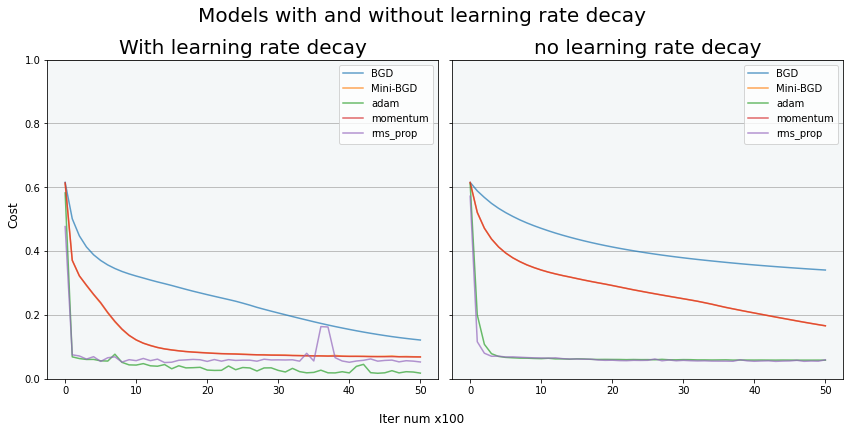

In [24]:
all_models_costs = pd.concat([models_costs, models_decay_costs])
Visualization.gradient_visualization(all_models_costs.cost, 100, "Models with and without learning rate decay")

Learning rate decay is an useful tool. It give a possibility to use higher learning rate at the beginning of a training, where it is needed - gradient descen takes bigger steps. After some iterations (epochs) we can decrase learning rate value - we want this, because it will enable gradient descent to take smaller step, hance we won't oscilate around minimum, we will simply go minimize cost funcition more.

It the above example every learining goes like this and we:
- get better results for BGD, Mini-batch GD and momentum
- get similar results for RMS Prop and Adam oplimalization methods

Maybe this dataset does not show well learning rate decay adventages on Adam and RMS Prop, but you get the idea. Learning rate decay is really powerful tool.

Let's also compare metrics for models learned with and without learning rate decay:

In [25]:
print(f"Model without learning rate decay:\n{metrics}\n", f"Model with learning rate decay:\n{metrics_decay}", sep = "\n")

Model without learning rate decay:
          accuracy        f1  precision    recall       AUC
BGD       0.866667  0.869281   0.852564  0.886667  0.934933
Mini-BGD  0.946667  0.946667   0.946667  0.946667  0.946667
momentum  0.946667  0.946667   0.946667  0.946667  0.989422
rms_prop  0.976667  0.976589   0.979866  0.973333  0.997956
adam      0.976667  0.976589   0.979866  0.973333  0.997956

Model with learning rate decay:
          accuracy        f1 precision    recall       AUC
BGD           0.96  0.960265  0.953947  0.966667  0.995067
Mini-BGD  0.973333  0.973333  0.973333  0.973333  0.997111
momentum  0.973333  0.973333  0.973333  0.973333    0.9972
rms_prop  0.976667  0.976744   0.97351      0.98    0.9986
adam      0.993333  0.993289       1.0  0.986667  0.999911


If we analyze metrics, we can see that we get higer scores for models with scheduled learning rate decay. For Ada we get 99% accuracy/f1 score. That pretty impressive. Let's see its decision boundary (I wasn't saving models, but we got lucky that last model has the best performance, so I spontaneously decided to plot its decision boundary)

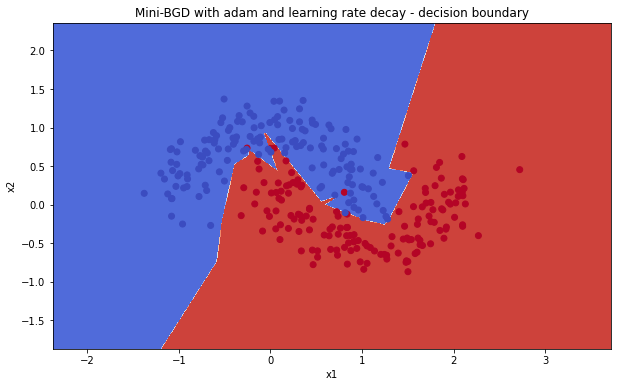

In [26]:
plt.figure(figsize=(10, 6))
plt.title("Mini-BGD with adam and learning rate decay - decision boundary")
Visualization.plot_decision_boundary(lambda x: model_decay.predict(x.T), train_x, train_y)

## Summary
Optimalization methods have a lot of adventages:
- to speed up learning we can update gradients more frequently, due to mini-batch gradient descent.
- to converge more smoothly we can use momentum, rms_pro and adam oplimalization methods
- to avoid oscilation around local minima or fasten/slow learning where we want the learning rate decay has a lot to offer

In this notebook, the best results was obtained for mini-batch gradient descent with adam optimalization and learning rate decay.